# Hyperparameter Optimization In Ludwig



Demonstrates hyper-parameter tuning capabilities of Ludwig. The following steps occur in this notebook:
* Training data is prepared for use
* Programmatically create Ludwig config dictionary from the training data dataframe
* Setup parameter space for hyperparameter optimization
* Perform two hyperparameter runs
  * Parallel workers using random search strategy
  * Serial processing using random search strategy
  * Parallel workers using grid search strategy
* Demonstrate various Ludwig visualizations for hyperparameter optimization

## Import required libraries

In [1]:
import warnings
warnings.simplefilter('ignore')

import logging
import shutil
import tempfile
import datetime

import pandas as pd
import numpy as np

from ludwig.api import LudwigModel
from ludwig.utils.data_utils import load_json
from ludwig.utils.defaults import merge_with_defaults, ACCURACY
from ludwig.utils.tf_utils import get_available_gpus_cuda_string
from ludwig.visualize import learning_curves
from ludwig.hyperopt.execution import get_build_hyperopt_executor
from ludwig.hyperopt.sampling import (get_build_hyperopt_sampler)
from ludwig.hyperopt.run import hyperopt
from ludwig.hyperopt.utils import update_hyperopt_params_with_defaults
from ludwig.visualize import hyperopt_results_to_dataframe, hyperopt_hiplot_cli, hyperopt_report_cli

from sklearn.model_selection import train_test_split

## Retrieve data for training

In [2]:
train_df = pd.read_csv('./data/winequalityN.csv')
train_df.shape

(6497, 13)

## Standardize column names to replace spaces(" ") with underscore("_")

In [3]:
new_col = []
for i in range(len(train_df.columns)):
    new_col.append(train_df.columns[i].replace(' ', '_'))
    
train_df.columns = new_col


## Data Set Overview

In [4]:
train_df.dtypes

type                     object
fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

## Create training and test data sets

In [5]:
train_df['quality'].value_counts().sort_index()

3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: quality, dtype: int64

In [6]:
# isolate the predictor variables only
predictor_vars = list(set(train_df.columns) - set(['quality']))

#extract categorical variables
categorical_vars = []
for p in predictor_vars:
    if train_df[p].dtype == 'object':
        categorical_vars.append(p)
        
print("categorical variables:", categorical_vars,'\n')

# get numerical variables
numerical_vars = list(set(predictor_vars) - set(categorical_vars))

print("numerical variables:", numerical_vars,"\n")

categorical variables: ['type'] 

numerical variables: ['free_sulfur_dioxide', 'volatile_acidity', 'chlorides', 'citric_acid', 'pH', 'fixed_acidity', 'sulphates', 'total_sulfur_dioxide', 'alcohol', 'residual_sugar', 'density'] 



In [7]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed_acidity,6487.0,7.216579,1.296750,3.80000,6.40000,7.00000,7.70000,15.90000
volatile_acidity,6489.0,0.339691,0.164649,0.08000,0.23000,0.29000,0.40000,1.58000
citric_acid,6494.0,0.318722,0.145265,0.00000,0.25000,0.31000,0.39000,1.66000
residual_sugar,6495.0,5.444326,4.758125,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6495.0,0.056042,0.035036,0.00900,0.03800,0.04700,0.06500,0.61100
free_sulfur_dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total_sulfur_dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6488.0,3.218395,0.160748,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6493.0,0.531215,0.148814,0.22000,0.43000,0.51000,0.60000,2.00000


In [8]:
for p in categorical_vars:
    print("unique values for",p,"is",train_df[p].nunique())

unique values for type is 2


## Create config

In [9]:
# template for config
config = {'input_features':[], 'output_features': [], 'training':{}}

# setup input features for categorical variables
for p in categorical_vars:
    a_feature = {'name': p.replace(' ','_'), 'type': 'category', 'representation': 'sparse'}
    config['input_features'].append(a_feature)


# setup input features for numerical variables
for p in numerical_vars:
    a_feature = {'name': p.replace(' ','_'), 'type': 'numerical', 
                'preprocessing': {'missing_value_strategy': 'fill_with_mean', 'normalization': 'zscore'}}
    config['input_features'].append(a_feature)

# set up output variable
config['output_features'].append({'name': 'quality', 'type':'category'})

# set up training
config['training'] = {'epochs': 20}

In [10]:
# View the config
print("config:")
config

config:


{'input_features': [{'name': 'type',
   'type': 'category',
   'representation': 'sparse'},
  {'name': 'free_sulfur_dioxide',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'volatile_acidity',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'chlorides',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'citric_acid',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'pH',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'fixed_acidity',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'sulp

## Define hyperparameter search space

In [11]:
SEED=13

hyperopt_configs = {
    "parameters": {
        "training.learning_rate": {
            "type": "float",
            "low": 0.0001,
            "high": 0.01,
            "space": "log",
            "steps": 3,
        },
        "training.batch_size": {
            "type": "int",
            "low": 32,
            "high": 256,
            "space": "log",
            "steps": 5,
            "base" : 2
        },
        "quality.fc_size": {
            "type": "int",
            "low": 32,
            "high": 256,
            "steps": 5
        },
        "quality.num_fc_layers": {
            'type': 'int',
            'low': 1,
            'high': 5,
            'space': 'linear',
            'steps': 4
        }
    },
    "goal": "minimize",
    'output_feature': "quality",
    'validation_metrics': 'loss'
}

# add hyperopt parameter space to the config
config['hyperopt'] = hyperopt_configs

## Train with optimal hyperparameters on the whole data set

In [12]:
# clean out old results
shutil.rmtree('./results_random_parallel', ignore_errors=True)
shutil.rmtree('./results_random_serial', ignore_errors=True)
shutil.rmtree('./results_grid_parallel', ignore_errors=True)
shutil.rmtree('./visualizations', ignore_errors=True)

#### Random Search with 4 parallel executors

In [13]:
%%time
print("starting:", datetime.datetime.now())
config['hyperopt']['executor'] = {'type': 'parallel', 'num_workers': 4}
config['hyperopt']['sampler'] = {'type': 'random', 'num_samples': 10}
random_parallel_results = hyperopt(
    config,
    dataset=train_df.sample(4000, random_state=42),  # limit number records for demonstration purposes
    output_directory='results_random_parallel'  # location to place results
)

starting: 2020-10-05 12:09:37.005311
{   'executor': {   'TF_REQUIRED_MEMORY_PER_WORKER': 100,
                    'epsilon': 0.01,
                    'epsilon_memory': 100,
                    'num_workers': 4,
                    'type': 'parallel'},
    'goal': 'minimize',
    'metric': 'loss',
    'output_feature': 'quality',
    'parameters': {   'quality.fc_size': {   'high': 256,
                                             'low': 32,
                                             'steps': 5,
                                             'type': 'int'},
                      'quality.num_fc_layers': {   'high': 5,
                                                   'low': 1,
                                                   'space': 'linear',
                                                   'steps': 4,
                                                   'type': 'int'},
                      'training.batch_size': {   'base': 2,
                                                 'hi

#### Random Search with serial executor

In [14]:
%%time
print("starting:", datetime.datetime.now())
config['hyperopt']['executor'] = {'type': 'serial'}
config['hyperopt']['sampler'] = {'type': 'random', 'num_samples': 10}
random_serial_results = hyperopt(
    config,
    dataset= train_df.sample(4000, random_state=42),  # limit number records for demonstration purposes
    output_directory='results_random_serial'
)

starting: 2020-10-05 12:11:18.942239
{   'executor': {'type': 'serial'},
    'goal': 'minimize',
    'metric': 'loss',
    'output_feature': 'quality',
    'parameters': {   'quality.fc_size': {   'high': 256,
                                             'low': 32,
                                             'steps': 5,
                                             'type': 'int'},
                      'quality.num_fc_layers': {   'high': 5,
                                                   'low': 1,
                                                   'space': 'linear',
                                                   'steps': 4,
                                                   'type': 'int'},
                      'training.batch_size': {   'base': 2,
                                                 'high': 256,
                                                 'low': 32,
                                                 'space': 'log',
                                              

#### Grid Search with 4 parallel executors (takes about 35 minutes)
To run the next cell, change it from `Raw NB Convert` to `Code` cell

### Note:
`random_parallel_results`, `random_serial_results` and `grid_parallel_results` are lists.  The first element in each list contains the best performing metric with the associated parameters.

## Convert hyperparameter optimization results to dataframe

#### Results For Random Search with 4 parallel executors

In [15]:
df1 = hyperopt_results_to_dataframe(
    random_parallel_results,
    hyperopt_configs['parameters'],
    hyperopt_configs['validation_metrics']
)
df1

,loss,quality.fc_size,quality.num_fc_layers,training.batch_size,training.learning_rate
0,0.893789,248,2,190,0.007944
1,0.959020,208,3,127,0.002552
2,1.063661,117,3,43,0.000107
3,1.068875,45,4,142,0.003507
4,1.073478,184,5,61,0.002197
5,1.077572,124,4,58,0.000364
6,1.096368,242,4,37,0.000152
7,1.101610,112,1,252,0.002193
8,1.107637,69,5,202,0.000138
9,1.510302,46,1,181,0.000196


#### Results for Random Search with serial executor

In [16]:
df2 = hyperopt_results_to_dataframe(
    random_serial_results,
    hyperopt_configs['parameters'],
    hyperopt_configs['validation_metrics']
)
df2

,loss,quality.fc_size,quality.num_fc_layers,training.batch_size,training.learning_rate
0,0.892174,42,1,190,0.007072
1,1.078235,90,3,80,0.000681
2,1.079202,102,4,72,0.000739
3,1.084151,228,5,52,0.001291
4,1.084482,167,2,86,0.000315
5,1.091582,109,2,90,0.000995
6,1.097158,247,2,211,0.000182
7,1.113529,248,1,72,0.006051
8,1.138526,219,2,164,0.000181
9,1.192490,32,4,46,0.000116


#### Results for Grid Search with 4 parallel executors
To run the next cell convert from `Raw NB Convert` to `Code` cell

## Example Hyperopt Visualizations

#### Report results of the a hyperparameter optimization run

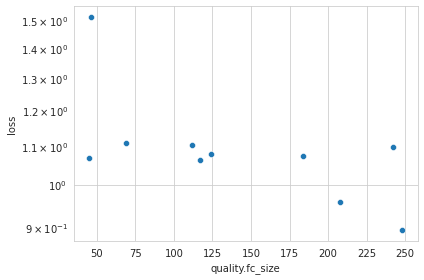

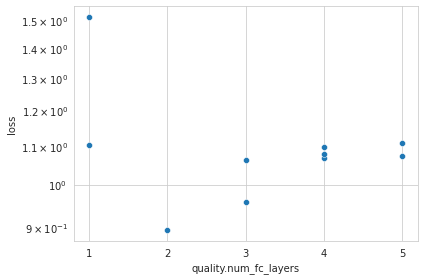

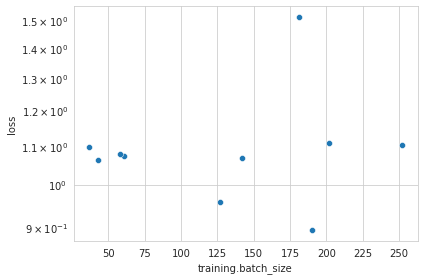

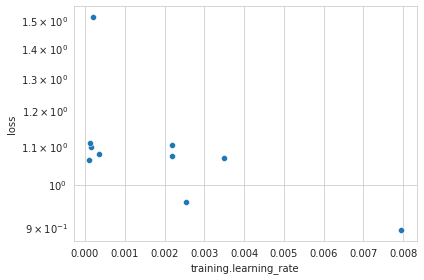

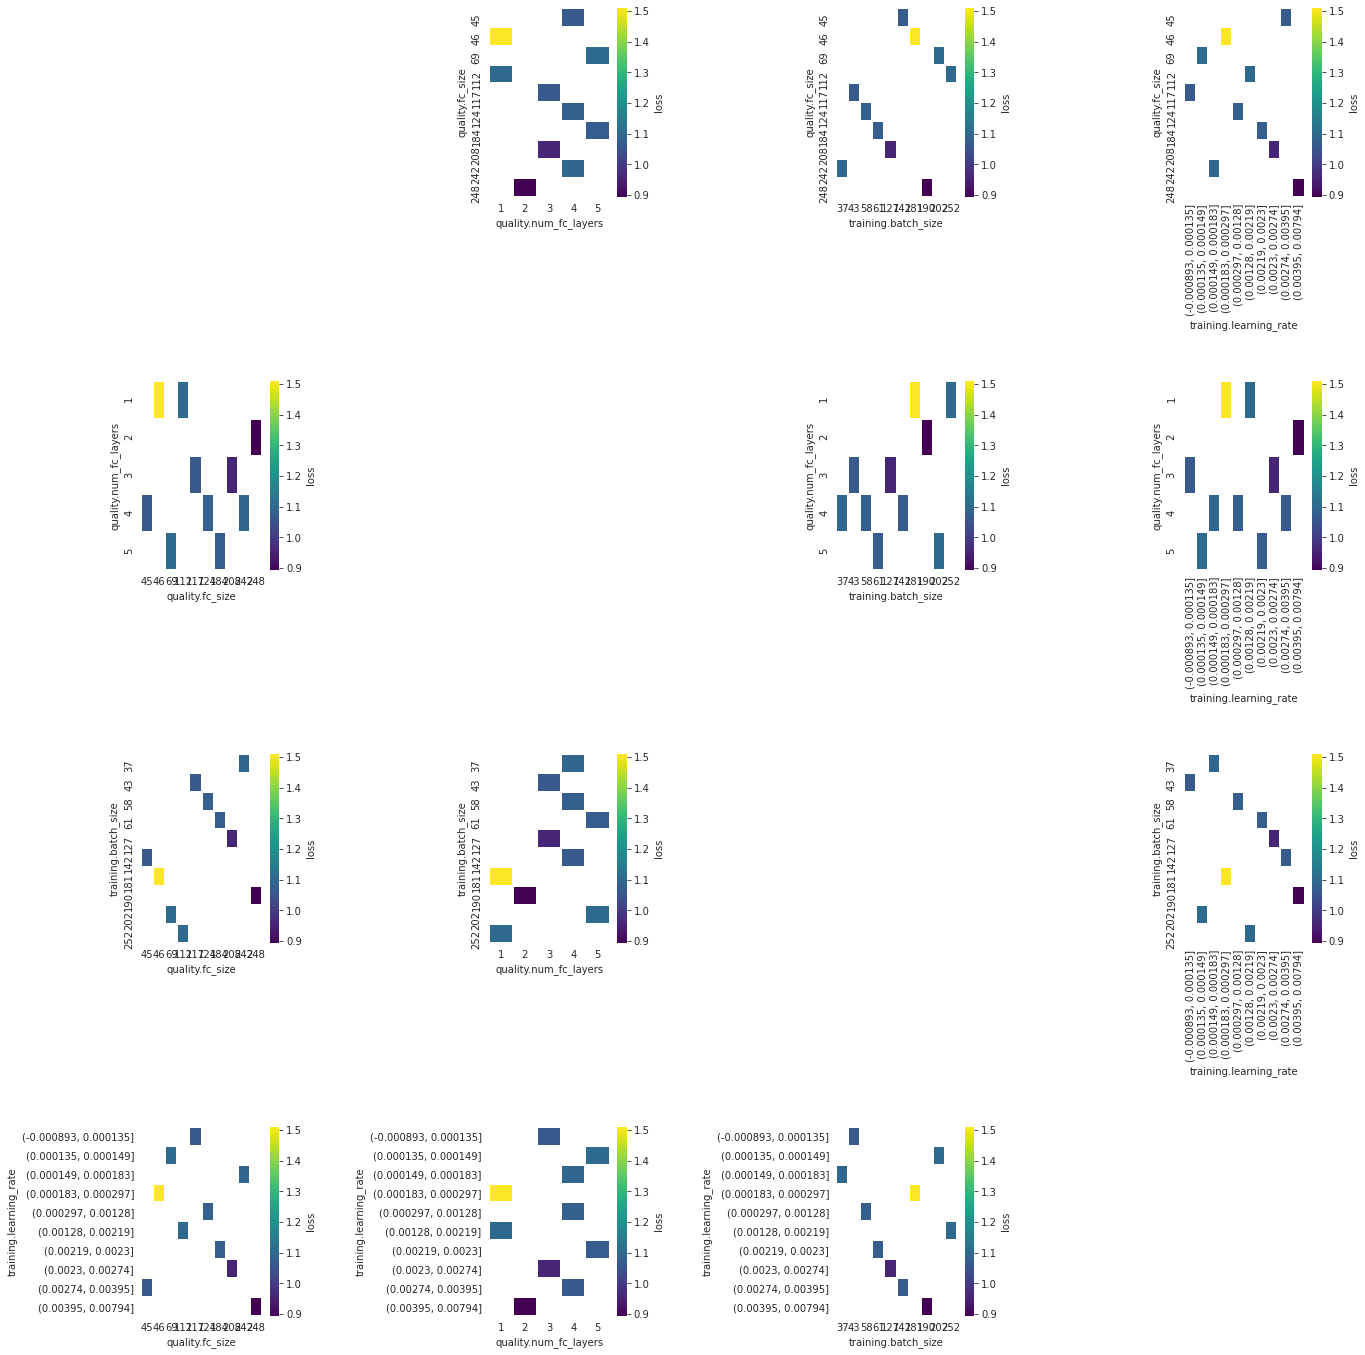

In [17]:
hyperopt_report_cli(
    'results_random_parallel/hyperopt_statistics.json',
    output_directory='./visualizations'
)

#### Generate parallel coordinates plot on hyperparameter optimization

In [18]:
hyperopt_hiplot_cli(
    'results_random_parallel/hyperopt_statistics.json',
    output_directory='./visualizations'
)

To view parallel coordinates plot, using your browser open html page in the `visualizations` directory, i.e, `visualizations/hyperopt_hiplot.html`.  The browser should display something similar to the image below.

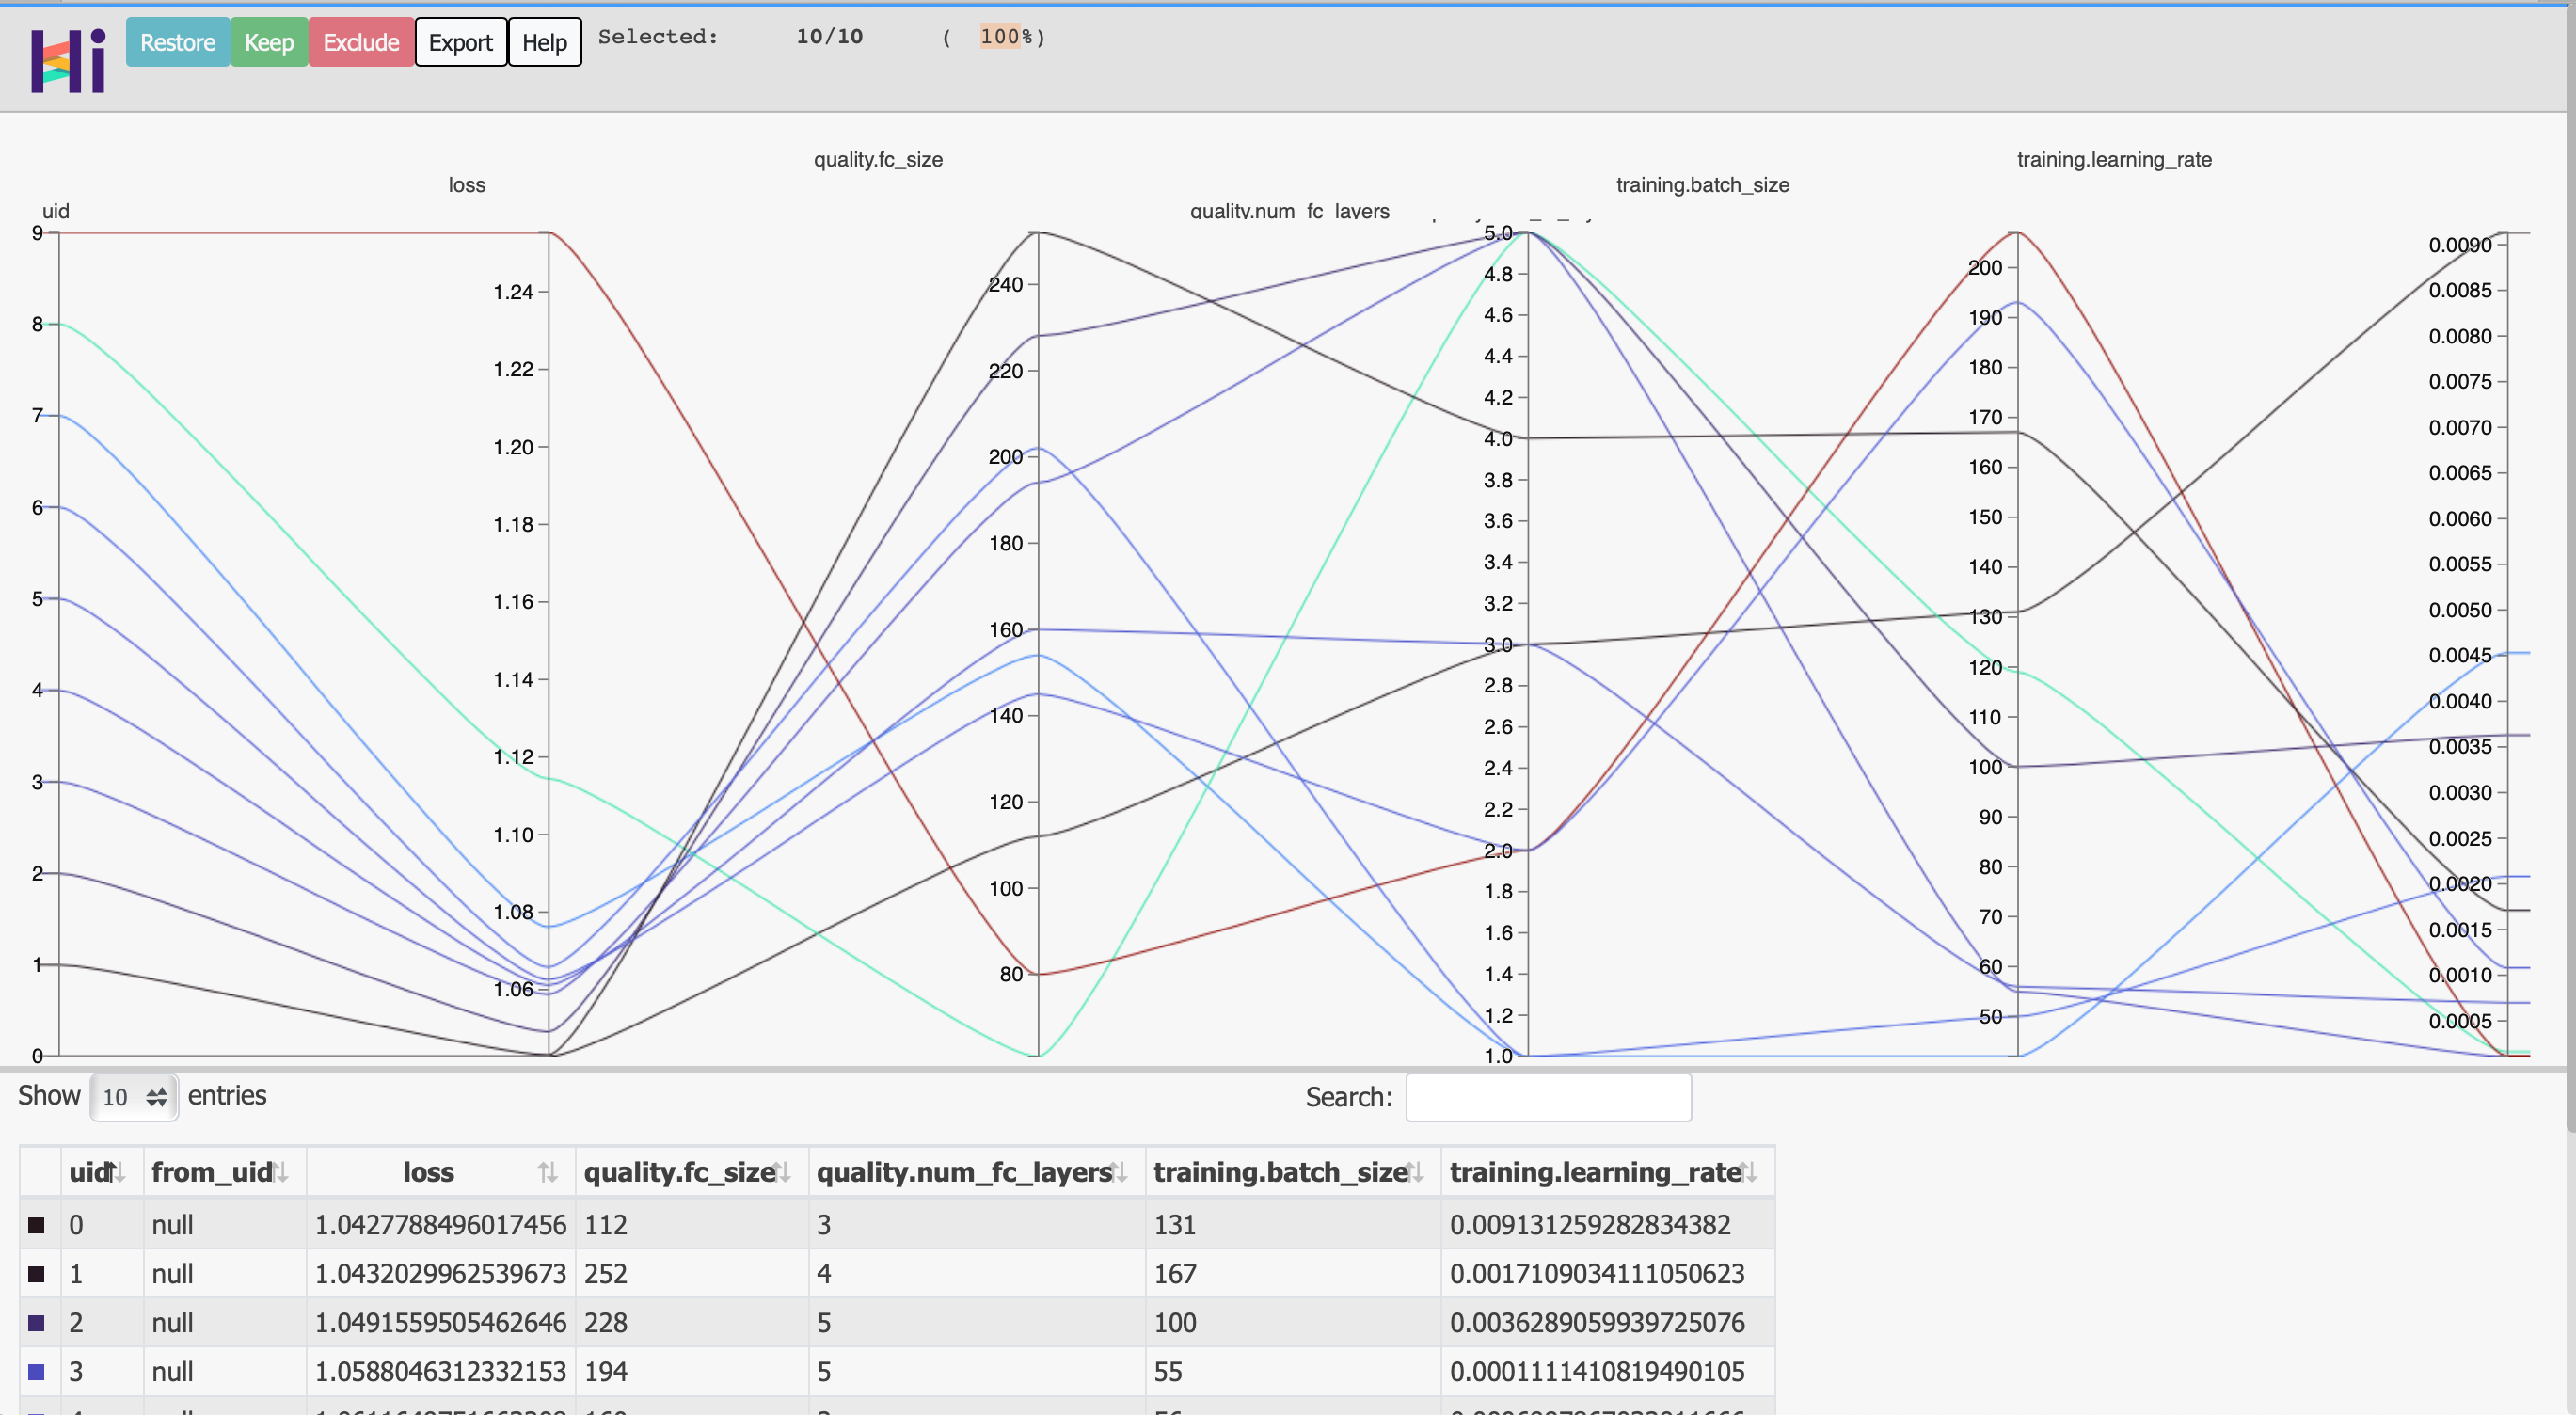

In [19]:
from IPython.display import Image
Image(filename='./images/parallel_coordinates_plot.png')